In [1]:
#import libraries
import random
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
import shap
from IPython.display import display, clear_output

In [2]:
f1 = open("train.txt","r")
raw_data = f1.readlines()
f1.close()

In [3]:
from collections import defaultdict
node_set = set()
in_neighbour = defaultdict(set)  
out_neighbour = defaultdict(set) 
for instance in raw_data:  
    source,sink_list = instance.split()[0],instance.split()[1:]
    node_set.add(source)
    out_neighbour[source] = set(sink_list)
    for node in sink_list:
        node_set.add(node)
        in_neighbour[node].add(source)
#print (in_neighbour)
print (len(node_set))

4867136


In [4]:
len(in_neighbour)

4867136

In [5]:
len(out_neighbour)

20000

In [6]:
import math    

def resource_allocation(node1,node2):
    result = 0
    common1 = in_neighbour[node1].intersection(in_neighbour[node2]).union(out_neighbour[node1].intersection(out_neighbour[node2]))
    common2 = in_neighbour[node1].intersection(out_neighbour[node2]).union(out_neighbour[node1].intersection(in_neighbour[node2]))
    common = common1.union(common2)        
    for node in common:
        result += 1/(len(out_neighbour[node])+len(in_neighbour[node]))
    return result

def shared(node1,node2):
    return len(in_neighbour[node1].intersection(in_neighbour[node2])) + len(out_neighbour[node1].intersection(out_neighbour[node2]))

# |A∩B|/|A∪B|
def jaccard_distance(node1, node2):
    in_neighbour_union = len(in_neighbour[node1].union(in_neighbour[node2]))
    out_neighbour_union = len(out_neighbour[node1].union(out_neighbour[node2]))
    
    if in_neighbour_union == 0 and out_neighbour_union == 0:
        return 0
    
    return shared(node1,node2)/(in_neighbour_union+out_neighbour_union)

def cosine_distance(node1, node2):
    source_degrees = len(in_neighbour[node1]) + len(out_neighbour[node1])
    sink_degrees = len(in_neighbour[node2]) + len(out_neighbour[node2])
    
    if source_degrees == 0 or sink_degrees == 0:
        return 0
    
    return shared(node1, node2)/math.sqrt(source_degrees*sink_degrees)

#Sxy=∑z∈Γ(x)∩Γ(y) 1/logkz.
def adamic_adar(node1, node2):
    result = 0
    
    intersection = in_neighbour[node1].intersection(in_neighbour[node2]).union(out_neighbour[node1].intersection(out_neighbour[node2]))
    for node in intersection:
        degree = len(in_neighbour[node]) + len(out_neighbour[node])
        if degree == 1:
            continue
        result += 1/math.log(degree)
    return result

# Sxy=kx⋅ky
def preferential_attachment(node1, node2):
    source_degree = len(in_neighbour[node1])+len(out_neighbour[node1])
    sink_degree = len(in_neighbour[node2])+len(out_neighbour[node2])
    return source_degree*sink_degree


def follow_back(node1, node2):
    try:
        if node2 in in_neighbour[node1]:
            return int(1)
        else:
            return int(0)
    except:
        return int(0)   

#these simple features are probably the best one of all
def cal_follows(node1, node2):
    numFollowersSource = len(in_neighbour[node1])
    numFolloweesSource = len(out_neighbour[node1])
    numFollowersSink = len(in_neighbour[node2])
    numFolloweesSink = len(out_neighbour[node2])
    numCommonFollowers = len(in_neighbour[node1].intersection(in_neighbour[node2]))
    numCommonFollowees = len(out_neighbour[node1].intersection(out_neighbour[node2]))
    
    return [numFollowersSource, numFolloweesSource, numFollowersSink, numFolloweesSink, numCommonFollowers, numCommonFollowees]

def get_feature(node1,node2):
    result=[]
    result.append(resource_allocation(node1,node2))
    result.append(jaccard_distance(node1,node2))
    result.extend(knn(node1,node2))
    result.append(cosine_distance(node1,node2))
    result.append(adamic_adar(node1,node2))
    result.append(preferential_attachment(node1,node2))
    result.append(follow_back(node1,node2))
    result.extend(cal_follows(node1, node2))
    
    return result

In [7]:
g={}
data=open('train.txt','r')
for line in data:
	ints = [int(x) for x in line.split()]
	g[ints[0]] = ints[1:]    

In [8]:
#clean out nodes that follow 0 people
clean_g={}
for key in g:
    if len(g[key]) > 0:
        clean_g[key] = g[key]

In [9]:
def get_trainset(n_neg,n_pos):

    training_set = []

    for i in range(n_neg):
        if i%100==0: 
            clear_output(wait=True)
            display('===>' + str(i) +  '/' + str(n_neg) )       
            
        source_array=np.array(list(clean_g.keys()))
        sink_choice=np.array(list(clean_g.keys()))

        sink_source=np.random.choice(sink_choice)

        source=np.random.choice(source_array)
        sink=np.random.choice(np.array(clean_g[sink_source]))
        source=str(source)
        sink=str(sink)

        if int(sink) in clean_g[int(source)]:
            label=1
        else:
            label=0

        outcome = get_feature(source,sink)

        outcome.append(label)

        training_set.append(outcome)

    #pos
    for i in range(n_pos):
        if i%100==0: 
            clear_output(wait=True)
            display('===>' + str(i) +  '/' + str(n_neg) )    
            
        source_list=np.array(list(clean_g.keys()))
        source=np.random.choice(source_list)    
        sink_list=clean_g[source]
        sink=np.random.choice(sink_list) 

        source=str(source)
        sink=str(sink)

        if int(sink) in clean_g[int(source)]:
            label=1
        else:
            label=0

        outcome = get_feature(source,sink)

        outcome.append(label)

        training_set.append(outcome)

    print(len(training_set))    

    columns=[ 'allocation', 'jaccard', 'k1', 'k2',
           'k3', 'k4', 'cosine','adamic_adar','pref_attachment',
             'followback',
             'numFollowersSource', 'numFolloweesSource', 'numFollowersSink', 'numFolloweesSink', 
             'numCommonFollowers', 'numCommonFollowees','label']

    data=pd.DataFrame(training_set,columns=columns)

    return data

In [10]:
data=get_trainset(10000,10000)

'===>9900/10000'

20000


In [11]:
data.head()

,allocation,jaccard,k1,k2,k3,k4,cosine,adamic_adar,pref_attachment,followback,numFollowersSource,numFolloweesSource,numFollowersSink,numFolloweesSink,numCommonFollowers,numCommonFollowees,label
0,0.0,0.0,0.133631,0.577350,0.710981,0.077152,0.0,0.0,116,0,3,55,2,0,0,0,0
1,0.0,0.0,0.083918,0.353553,0.437472,0.029670,0.0,0.0,1036,0,7,141,7,0,0,0,0
2,0.0,0.0,0.707107,0.090167,0.797274,0.063758,0.0,0.0,244,0,1,1,122,0,0,0,0
3,0.0,0.0,0.156174,0.136083,0.292257,0.021253,0.0,0.0,2491,0,7,40,53,0,0,0,0
4,0.0,0.0,0.316228,0.377964,0.694192,0.119523,0.0,0.0,72,0,3,9,6,0,0,0,0


In [12]:
def split_val_train_test_xgb(data):
    X=data[['allocation', 'jaccard', 'k1', 'k2',
           'k3', 'k4', 'cosine','adamic_adar','pref_attachment',
             'followback',
             'numFollowersSource', 'numFolloweesSource', 'numFollowersSink', 'numFolloweesSink', 
             'numCommonFollowers', 'numCommonFollowees']]
    y=data['label']
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.4, random_state=42)
    X_test, X_val, y_test, y_val = train_test_split(X, y, test_size=0.5, random_state=42)
    
    dtrain = xgb.DMatrix(X_train,label=y_train)
    dval = xgb.DMatrix(X_val,label=y_val)
    dtest=xgb.DMatrix(X_test,label=y_test)
    
    return dtrain,dval,dtest,X_train,y_test

In [13]:
dtrain,dval,dtest,X_train,y_test=split_val_train_test_xgb(data)

In [14]:
params={'objective':'binary:logistic','eval_metric':'auc','max_depth':4}
#        'lambda':1,'colsample_bylevel':0.8,'gamma':2,
#        'min_child_weight':5,'subsample':1,'scale_pos_weight':1}
num_round=500
early_stopping_rounds=10
evals_result={}

model=xgb.train(params,dtrain,num_round,[(dtrain,'train'),(dval,'eval')],early_stopping_rounds=
               early_stopping_rounds,
               evals_result=evals_result)


[0]	train-auc:0.826352	eval-auc:0.825369
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 10 rounds.
[1]	train-auc:0.862432	eval-auc:0.857821
[2]	train-auc:0.867278	eval-auc:0.862541
[3]	train-auc:0.873836	eval-auc:0.869101
[4]	train-auc:0.875938	eval-auc:0.87155
[5]	train-auc:0.880365	eval-auc:0.875971
[6]	train-auc:0.882988	eval-auc:0.877853
[7]	train-auc:0.885455	eval-auc:0.879369
[8]	train-auc:0.887352	eval-auc:0.881414
[9]	train-auc:0.888891	eval-auc:0.882479
[10]	train-auc:0.889989	eval-auc:0.883628
[11]	train-auc:0.892306	eval-auc:0.885407
[12]	train-auc:0.893314	eval-auc:0.886184
[13]	train-auc:0.894821	eval-auc:0.887134
[14]	train-auc:0.895341	eval-auc:0.887504
[15]	train-auc:0.896986	eval-auc:0.888177
[16]	train-auc:0.897981	eval-auc:0.888893
[17]	train-auc:0.89852	eval-auc:0.889368
[18]	train-auc:0.898835	eval-auc:0.889496
[19]	train-auc:0.900165	eval-auc:0.890145
[20]	train-auc:0.900871	eval-au

In [15]:
preds=model.predict(dtest)
print('AUC = ',roc_auc_score(y_test, preds))

AUC =  0.9460254968759023


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


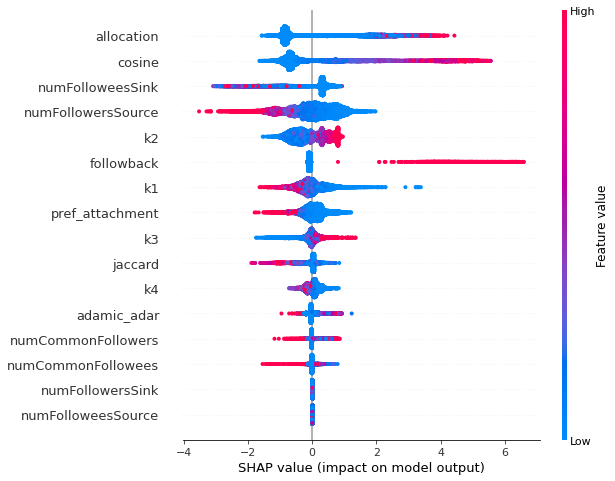

In [16]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values,X_train)

In [17]:
#get Testing Data
import csv
fp = open("test-public.txt","r")
head = fp.readline()
test_file = fp.readlines()
fp.close()
predict_list=[]
print (test_file[0])
test_data = []
for line in test_file:
    Id,node1,node2 = line.split()
    outcome = get_feature(node1,node2)
    test_data.append(outcome)
    
test=pd.DataFrame(test_data,columns=['allocation', 'jaccard', 'k1', 'k2',
           'k3', 'k4', 'cosine','adamic_adar','pref_attachment',
             'followback',
             'numFollowersSource', 'numFolloweesSource', 'numFollowersSink', 'numFolloweesSink', 
             'numCommonFollowers', 'numCommonFollowees'])

1	3563811	3600160



In [18]:
test.head(10)

,allocation,jaccard,k1,k2,k3,k4,cosine,adamic_adar,pref_attachment,followback,numFollowersSource,numFolloweesSource,numFollowersSink,numFolloweesSink,numCommonFollowers,numCommonFollowees
0,0.000000,0.000000,0.213201,0.182574,0.395775,0.038925,0.000000,0.000000,696,0,3,21,29,0,0,0
1,0.000000,0.000000,0.117851,0.316228,0.434079,0.037268,0.000000,0.000000,756,0,13,71,9,0,0,0
2,0.004409,0.006667,0.069673,0.235702,0.305376,0.016422,0.028733,0.304319,4845,0,80,205,17,0,2,0
3,0.000027,0.003497,0.044412,0.164399,0.208811,0.007301,0.014371,0.178377,19368,0,32,506,36,0,2,0
4,0.000000,0.000000,0.229416,0.145865,0.375281,0.033464,0.000000,0.000000,1058,0,5,18,46,0,0,0
5,0.000000,0.000000,0.140028,0.707107,0.847135,0.099015,0.000000,0.000000,55,0,5,50,1,0,0,0
6,0.000011,0.002165,0.055216,0.333333,0.388549,0.018405,0.016575,0.087795,3640,0,128,327,8,0,1,0
7,0.000022,0.001779,0.078087,0.140028,0.218115,0.010934,0.006244,0.093358,25650,0,350,163,50,0,1,0
8,0.000000,0.000000,0.032092,0.447214,0.479305,0.014352,0.000000,0.000000,4276,0,99,970,4,0,0,0
9,0.000000,0.000000,0.070888,0.128037,0.198925,0.009076,0.000000,0.000000,12120,0,4,198,60,0,0,0


In [19]:
dtestset = xgb.DMatrix(test)

In [20]:
#predict
preds=model.predict(dtestset)

In [21]:
Id=np.arange(1,2001)
test['Id']=Id
test['Predicted']=preds
dfcsv=test[['Id','Predicted']]

In [22]:
dfcsv.to_csv('XGBoost_Lessparam.csv',index=False)